## Графичкское отображение 

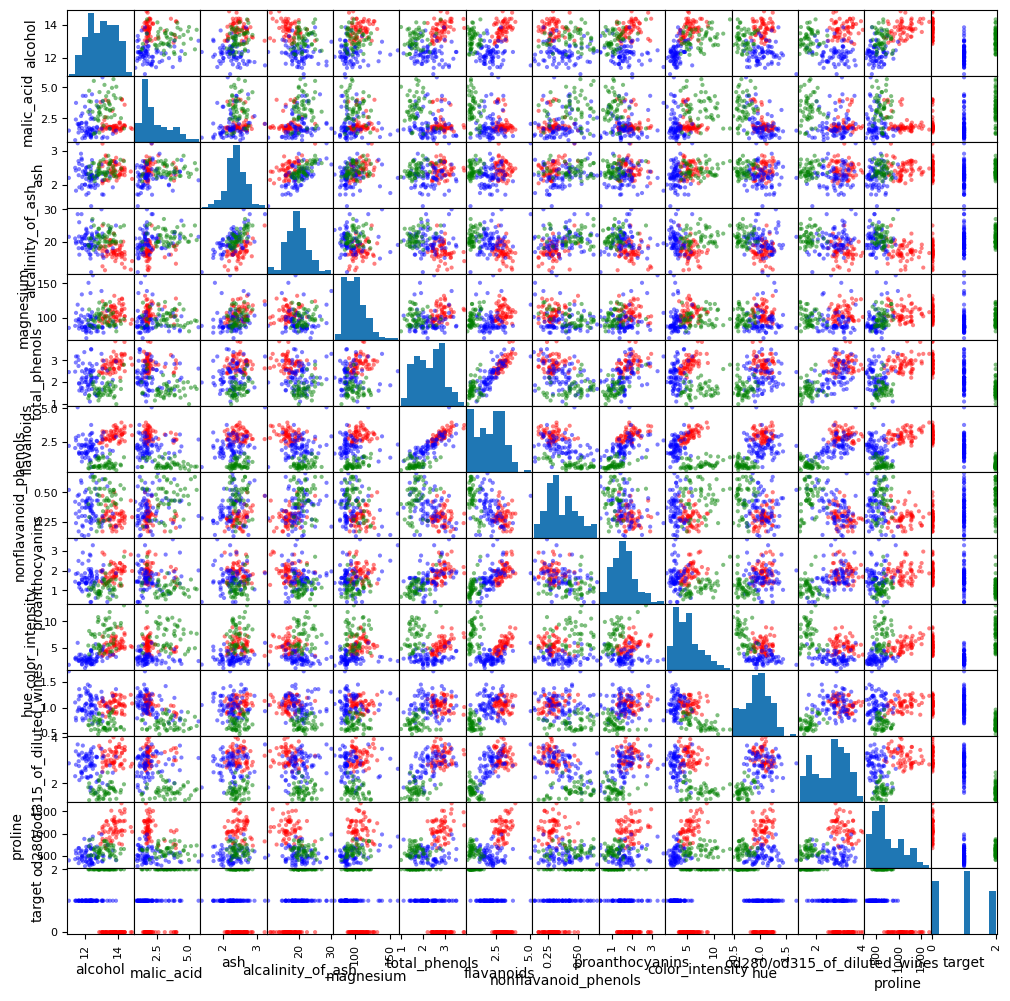

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

# Загрузка данных
sheet = pd.read_csv('V2_classification_lr3.csv')

# Получение значений целевой переменной
target = sheet['target']

# Создание цветовой карты на основе значений target
colors = target.map({0: 'red', 1: 'blue', 2:'green'})  # Замените 0 и 1 на ваши значения целевой переменной и соответствующие цвета

# Построение матрицы рассеяния
scatter_matrix(sheet, figsize=(12, 12), c=colors, alpha=0.5, diagonal='hist')

# Показ графика
plt.show()


## Информация про данные

In [4]:
print(sheet.shape)
print(sheet.dtypes)
print(sheet.describe())
print(sheet.info())

(178, 14)
alcohol                         float64
malic_acid                      float64
ash                             float64
alcalinity_of_ash               float64
magnesium                       float64
total_phenols                   float64
flavanoids                      float64
nonflavanoid_phenols            float64
proanthocyanins                 float64
color_intensity                 float64
hue                             float64
od280/od315_of_diluted_wines    float64
proline                         float64
target                            int64
dtype: object
          alcohol  malic_acid         ash  alcalinity_of_ash   magnesium  \
count  178.000000  178.000000  178.000000         178.000000  178.000000   
mean    13.000618    2.336348    2.366517          19.494944   99.741573   
std      0.811827    1.117146    0.274344           3.339564   14.282484   
min     11.030000    0.740000    1.360000          10.600000   70.000000   
25%     12.362500    1.602500    2.2

Проверка на сбалансированность датасета
---

In [5]:
class_distribution = sheet['target'].value_counts()
print(class_distribution)

target
1    71
0    59
2    48
Name: count, dtype: int64


Вывод: не сбалансировано

In [3]:
print(sheet.shape)
print(sheet.dtypes)

(178, 14)
alcohol                         float64
malic_acid                      float64
ash                             float64
alcalinity_of_ash               float64
magnesium                       float64
total_phenols                   float64
flavanoids                      float64
nonflavanoid_phenols            float64
proanthocyanins                 float64
color_intensity                 float64
hue                             float64
od280/od315_of_diluted_wines    float64
proline                         float64
target                            int64
dtype: object


## RNN на стандартизированных данных

In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from keras.utils import to_categorical
from sklearn.metrics import f1_score


# Функция для получения и стандартизации данных
def get_train_test_and_val_data():
    sheet = pd.read_csv('V2_classification_lr3.csv')
    
    sheet_x = sheet.iloc[:, :13]
    sheet_y = sheet['target']
    
    # Преобразование меток в формат one-hot
    sheet_y = to_categorical(sheet_y, num_classes=3)  # Предполагается, что классы 0, 1, 2
    
    scaler = StandardScaler()
    sheet_x = scaler.fit_transform(sheet_x)
   
    seed = 7
    test_size = 0.2
    val_size = 0.25
    
    x_train, x_test, y_train, y_test = train_test_split(sheet_x, sheet_y, test_size=test_size, random_state=seed)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size, random_state=seed)
    
    return x_train, y_train, x_test, y_test, x_val, y_val 

x_train, y_train, x_test, y_test, x_val, y_val = get_train_test_and_val_data()
print(x_train.shape)

# Изменение формы входных данных для RNN
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

# Создание модели
model = Sequential()
model.add(SimpleRNN(200, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(3, activation='softmax'))  # Для многоклассовой классификации

# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Обучение модели
history = model.fit(x_train, y_train, epochs=100, batch_size=16, validation_data=(x_val, y_val))

# Оценка модели 
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)
y_val_pred = model.predict(x_val)

 
y_train_pred_labels = np.argmax(y_train_pred, axis=1)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)
y_val_pred_labels = np.argmax(y_val_pred, axis=1)

 
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
y_val_labels = np.argmax(y_val, axis=1)

 
f1_micro_train = f1_score(y_train_labels, y_train_pred_labels, average='micro')   
f1_macro_train = f1_score(y_train_labels, y_train_pred_labels, average='macro')   
f1_weighted_train = f1_score(y_train_labels, y_train_pred_labels, average='weighted')  

f1_micro_test = f1_score(y_test_labels, y_test_pred_labels, average='micro')   
f1_macro_test = f1_score(y_test_labels, y_test_pred_labels, average='macro')   
f1_weighted_test = f1_score(y_test_labels, y_test_pred_labels, average='weighted')  

f1_micro_val = f1_score(y_val_labels, y_val_pred_labels, average='micro')   
f1_macro_val = f1_score(y_val_labels, y_val_pred_labels, average='macro')   
f1_weighted_val = f1_score(y_val_labels, y_val_pred_labels, average='weighted')  

# Вывод результатов
print(f'F1 Micro Train: {f1_micro_train}')
print(f'F1 Macro Train: {f1_macro_train}')
print(f'F1 Weighted Train: {f1_weighted_train}')
print()
print(f'F1 Micro Test: {f1_micro_test}')
print(f'F1 Macro Test: {f1_macro_test}')
print(f'F1 Weighted Test: {f1_weighted_test}')
print()
print(f'F1 Micro Val: {f1_micro_val}')
print(f'F1 Macro Val: {f1_macro_val}')
print(f'F1 Weighted Val: {f1_weighted_val}')


(106, 13)
Epoch 1/100


c:\Users\kasi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5208 - loss: 0.9901 - val_accuracy: 0.8333 - val_loss: 0.6756
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8727 - loss: 0.6684 - val_accuracy: 0.9167 - val_loss: 0.4902
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9516 - loss: 0.4828 - val_accuracy: 0.9444 - val_loss: 0.3751
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9755 - loss: 0.3350 - val_accuracy: 0.9444 - val_loss: 0.3024
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9778 - loss: 0.2738 - val_accuracy: 0.9167 - val_loss: 0.2540
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9902 - loss: 0.2287 - val_accuracy: 0.9444 - val_loss: 0.2192
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9785 - loss: 0.1862 - val_accuracy: 0.9444 - val_loss: 0.1941
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9928 - loss: 0.1348 - val_accuracy: 0.9444 - val_loss: 0.1753
Epoch 9/100

## RNN на исходных данных

In [ ]:

def get_raw_train_test_and_val_data():
    sheet = pd.read_csv('V2_classification_lr3.csv')
    
    sheet_x = sheet.iloc[:, :13]
   
    sheet_y = sheet['target']
    
    # Преобразование меток в формат one-hot
    sheet_y = to_categorical(sheet_y, num_classes=3)  # Предполагается, что классы 0, 1, 2
    
   
    seed = 7
    test_size = 0.2
    val_size = 0.25
    
    x_train, x_test, y_train, y_test = train_test_split(sheet_x, sheet_y, test_size=test_size, random_state=seed)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size, random_state=seed)
    
    return x_train, y_train, x_test, y_test, x_val, y_val 


x_train, y_train, x_test, y_test, x_val, y_val = get_raw_train_test_and_val_data()
print(x_train.shape)


# Создание модели
model = Sequential()
model.add(SimpleRNN(200, activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(Dense(3, activation='softmax'))  # Для многоклассовой классификации

# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Обучение модели
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_val, y_val))

# Оценка модели 
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)
y_val_pred = model.predict(x_val)

 
y_train_pred_labels = np.argmax(y_train_pred, axis=1)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)
y_val_pred_labels = np.argmax(y_val_pred, axis=1)

 
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
y_val_labels = np.argmax(y_val, axis=1)

 
f1_micro_train = f1_score(y_train_labels, y_train_pred_labels, average='micro')   
f1_macro_train = f1_score(y_train_labels, y_train_pred_labels, average='macro')   
f1_weighted_train = f1_score(y_train_labels, y_train_pred_labels, average='weighted')  

f1_micro_test = f1_score(y_test_labels, y_test_pred_labels, average='micro')   
f1_macro_test = f1_score(y_test_labels, y_test_pred_labels, average='macro')   
f1_weighted_test = f1_score(y_test_labels, y_test_pred_labels, average='weighted')  

f1_micro_val = f1_score(y_val_labels, y_val_pred_labels, average='micro')   
f1_macro_val = f1_score(y_val_labels, y_val_pred_labels, average='macro')   
f1_weighted_val = f1_score(y_val_labels, y_val_pred_labels, average='weighted')  

# Вывод результатов
print(f'F1 Micro Train: {f1_micro_train}')
print(f'F1 Macro Train: {f1_macro_train}')
print(f'F1 Weighted Train: {f1_weighted_train}')
print()
print(f'F1 Micro Test: {f1_micro_test}')
print(f'F1 Macro Test: {f1_macro_test}')
print(f'F1 Weighted Test: {f1_weighted_test}')
print()
print(f'F1 Micro Val: {f1_micro_val}')
print(f'F1 Macro Val: {f1_macro_val}')
print(f'F1 Weighted Val: {f1_weighted_val}')

(106, 13)
Epoch 1/100


c:\Users\kasi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.2554 - loss: 122.6370 - val_accuracy: 0.2778 - val_loss: 75.6097
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3627 - loss: 58.3999 - val_accuracy: 0.3333 - val_loss: 38.9522
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3415 - loss: 25.8091 - val_accuracy: 0.3889 - val_loss: 16.1477
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3434 - loss: 16.2486 - val_accuracy: 0.3889 - val_loss: 14.6136
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3736 - loss: 12.6650 - val_accuracy: 0.1667 - val_loss: 5.1067
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2298 - loss: 5.5740 - val_accuracy: 0.3333 - val_loss: 4.7941
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3845 - loss: 4.5878 - val_accuracy: 0.3889 - val_loss: 5.5019
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3371 - loss: 5.4882 - val_accuracy: 0.3333 - val_loss: 4.1262
E

## Полносвязная сеть на Стандартизированных данных 

In [ ]:

x_train, y_train, x_test, y_test, x_val, y_val = get_train_test_and_val_data()
print(x_train.shape)


# Создание модели
model = Sequential()
model.add(Dense(64, activation='relu'))  # Первый скрытый слой
model.add(Dense(32, activation='relu'))  # Второй скрытый слой
model.add(Dense(3, activation='softmax'))  # Выходной слой для многоклассовой классификации

# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Обучение модели
history = model.fit(x_train, y_train, epochs=110, batch_size=32, validation_data=(x_val, y_val))

# Оценка модели 
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)
y_val_pred = model.predict(x_val)

 
y_train_pred_labels = np.argmax(y_train_pred, axis=1)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)
y_val_pred_labels = np.argmax(y_val_pred, axis=1)

 
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
y_val_labels = np.argmax(y_val, axis=1)

 
f1_micro_train = f1_score(y_train_labels, y_train_pred_labels, average='micro')   
f1_macro_train = f1_score(y_train_labels, y_train_pred_labels, average='macro')   
f1_weighted_train = f1_score(y_train_labels, y_train_pred_labels, average='weighted')  

f1_micro_test = f1_score(y_test_labels, y_test_pred_labels, average='micro')   
f1_macro_test = f1_score(y_test_labels, y_test_pred_labels, average='macro')   
f1_weighted_test = f1_score(y_test_labels, y_test_pred_labels, average='weighted')  

f1_micro_val = f1_score(y_val_labels, y_val_pred_labels, average='micro')   
f1_macro_val = f1_score(y_val_labels, y_val_pred_labels, average='macro')   
f1_weighted_val = f1_score(y_val_labels, y_val_pred_labels, average='weighted')  

# Вывод результатов
print(f'F1 Micro Train: {f1_micro_train}')
print(f'F1 Macro Train: {f1_macro_train}')
print(f'F1 Weighted Train: {f1_weighted_train}')
print()
print(f'F1 Micro Test: {f1_micro_test}')
print(f'F1 Macro Test: {f1_macro_test}')
print(f'F1 Weighted Test: {f1_weighted_test}')
print()
print(f'F1 Micro Val: {f1_micro_val}')
print(f'F1 Macro Val: {f1_macro_val}')
print(f'F1 Weighted Val: {f1_weighted_val}')

(106, 13)
Epoch 1/110
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4069 - loss: 1.1404 - val_accuracy: 0.6667 - val_loss: 0.9707
Epoch 2/110
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6252 - loss: 1.0029 - val_accuracy: 0.8056 - val_loss: 0.8639
Epoch 3/110
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8137 - loss: 0.8565 - val_accuracy: 0.8333 - val_loss: 0.7719
Epoch 4/110
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8853 - loss: 0.7383 - val_accuracy: 0.8333 - val_loss: 0.6919
Epoch 5/110
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8766 - loss: 0.6530 - val_accuracy: 0.8611 - val_loss: 0.6232
Epoch 6/110
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9578 - loss: 0.5805 - val_accuracy: 0.8889 - val_loss: 0.5619
Epoch 7/110
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9848 - loss: 0.5165 - val_accuracy: 0.8889 - val_loss: 0.5063
Epoch 8/110
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9941 - loss: 0.4395 - val_accuracy: 0.8889 - val_lo

## Полносвязная сеть на исходных данных

In [ ]:
# Загрузка данных
x_train, y_train, x_test, y_test, x_val, y_val = get_raw_train_test_and_val_data()
print(x_train.shape)

# Создание модели
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(x_train.shape[1],)))  # Первый скрытый слой
model.add(Dense(32, activation='relu'))  # Второй скрытый слой
model.add(Dense(3, activation='softmax'))  # Выходной слой для многоклассовой классификации

# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Обучение модели
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_val, y_val))

# Оценка модели 
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)
y_val_pred = model.predict(x_val)

 
y_train_pred_labels = np.argmax(y_train_pred, axis=1)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)
y_val_pred_labels = np.argmax(y_val_pred, axis=1)

 
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
y_val_labels = np.argmax(y_val, axis=1)

 
f1_micro_train = f1_score(y_train_labels, y_train_pred_labels, average='micro')   
f1_macro_train = f1_score(y_train_labels, y_train_pred_labels, average='macro')   
f1_weighted_train = f1_score(y_train_labels, y_train_pred_labels, average='weighted')  

f1_micro_test = f1_score(y_test_labels, y_test_pred_labels, average='micro')   
f1_macro_test = f1_score(y_test_labels, y_test_pred_labels, average='macro')   
f1_weighted_test = f1_score(y_test_labels, y_test_pred_labels, average='weighted')  

f1_micro_val = f1_score(y_val_labels, y_val_pred_labels, average='micro')   
f1_macro_val = f1_score(y_val_labels, y_val_pred_labels, average='macro')   
f1_weighted_val = f1_score(y_val_labels, y_val_pred_labels, average='weighted')  

# Вывод результатов
print(f'F1 Micro Train: {f1_micro_train}')
print(f'F1 Macro Train: {f1_macro_train}')
print(f'F1 Weighted Train: {f1_weighted_train}')
print()
print(f'F1 Micro Test: {f1_micro_test}')
print(f'F1 Macro Test: {f1_macro_test}')
print(f'F1 Weighted Test: {f1_weighted_test}')
print()
print(f'F1 Micro Val: {f1_micro_val}')
print(f'F1 Macro Val: {f1_macro_val}')
print(f'F1 Weighted Val: {f1_weighted_val}')

(106, 13)
Epoch 1/100


c:\Users\kasi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.2533 - loss: 163.2509 - val_accuracy: 0.2778 - val_loss: 119.8598
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2439 - loss: 97.4739 - val_accuracy: 0.2778 - val_loss: 56.2495
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2783 - loss: 37.3429 - val_accuracy: 0.3333 - val_loss: 7.9675
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4185 - loss: 7.3563 - val_accuracy: 0.4167 - val_loss: 13.9647
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3611 - loss: 15.0082 - val_accuracy: 0.4167 - val_loss: 16.8620
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5004 - loss: 15.7458 - val_accuracy: 0.3889 - val_loss: 18.4750
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4679 - loss: 15.7183 - val_accuracy: 0.6667 - val_loss: 14.8869
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5355 - loss: 13.8952 - val_accuracy: 0.5833 - val_loss: 12.

## Анализ лучшей модели 

Лучший результат у Полносвязной модели на стандартизированных данных

F1 Micro Train: 1.0
F1 Macro Train: 1.0
F1 Weighted Train: 1.0

F1 Micro Test: 0.9722222222222222
F1 Macro Test: 0.975983436853002
F1 Weighted Test: 0.9720151828847481

F1 Micro Val: 0.9722222222222222
F1 Macro Val: 0.9740129935032483
F1 Weighted Val: 0.972097284690988

## Определение лучших гиперпараметров

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from scikeras.wrappers import KerasClassifier



# Load data
x_train, y_train, x_test, y_test, x_val, y_val = get_train_test_and_val_data()

# Function to create model
def create_model(optimizer='adam', neurons=64):
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_shape=(x_train.shape[1],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(3, activation='softmax'))  # Output layer for multi-class classification
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# KerasClassifier wrapper
model = KerasClassifier(build_fn=create_model, verbose=0, neurons =32)

# Define parameters for search
param_grid = {
    'batch_size': [8 ,16, 32, ],
    'epochs': [10, 50, 200, 400],
    'optimizer': ['adam', 'sgd'],
    'neurons': [10, 32, 64,]  # This parameter will be passed to create_model
}

# Perform Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

# Output best parameters
print("Лучшие параметры: ", grid_result.best_params_)
print("Лучший балл: ", grid_result.best_score_)


c:\Users\kasi\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\kasi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Лучшие параметры:  {'batch_size': 16, 'epochs': 400, 'neurons': 10, 'optimizer': 'adam'}
Лучший балл:  0.9907407407407408


Лучшие параметры:  {'batch_size': 16, 'epochs': 400, 'neurons': 10, 'optimizer': 'adam'}
Лучший балл:  0.9907407407407408

## Показатели качества полученной в результате Grid поиска классификационной нейросетевой модели

In [ ]:

x_train, y_train, x_test, y_test, x_val, y_val = get_train_test_and_val_data()
print(x_train.shape)


# Создание модели
model = Sequential()
model.add(Dense(10, activation='relu'))  # Первый скрытый слой
model.add(Dense(32, activation='relu'))  # Второй скрытый слой
model.add(Dense(3, activation='softmax'))  # Выходной слой для многоклассовой классификации

# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Обучение модели
history = model.fit(x_train, y_train, epochs=400, batch_size=16, validation_data=(x_val, y_val))

# Оценка модели 
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)
y_val_pred = model.predict(x_val)

 
y_train_pred_labels = np.argmax(y_train_pred, axis=1)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)
y_val_pred_labels = np.argmax(y_val_pred, axis=1)

 
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
y_val_labels = np.argmax(y_val, axis=1)

 
f1_micro_train = f1_score(y_train_labels, y_train_pred_labels, average='micro')   
f1_macro_train = f1_score(y_train_labels, y_train_pred_labels, average='macro')   
f1_weighted_train = f1_score(y_train_labels, y_train_pred_labels, average='weighted')  

f1_micro_test = f1_score(y_test_labels, y_test_pred_labels, average='micro')   
f1_macro_test = f1_score(y_test_labels, y_test_pred_labels, average='macro')   
f1_weighted_test = f1_score(y_test_labels, y_test_pred_labels, average='weighted')  

f1_micro_val = f1_score(y_val_labels, y_val_pred_labels, average='micro')   
f1_macro_val = f1_score(y_val_labels, y_val_pred_labels, average='macro')   
f1_weighted_val = f1_score(y_val_labels, y_val_pred_labels, average='weighted')  

# Вывод результатов
print(f'F1 Micro Train: {f1_micro_train}')
print(f'F1 Macro Train: {f1_macro_train}')
print(f'F1 Weighted Train: {f1_weighted_train}')
print()
print(f'F1 Micro Test: {f1_micro_test}')
print(f'F1 Macro Test: {f1_macro_test}')
print(f'F1 Weighted Test: {f1_weighted_test}')
print()
print(f'F1 Micro Val: {f1_micro_val}')
print(f'F1 Macro Val: {f1_macro_val}')
print(f'F1 Weighted Val: {f1_weighted_val}')

(106, 13)
Epoch 1/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2836 - loss: 1.1230 - val_accuracy: 0.3889 - val_loss: 1.0676
Epoch 2/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4938 - loss: 1.0084 - val_accuracy: 0.5556 - val_loss: 1.0158
Epoch 3/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6715 - loss: 0.9706 - val_accuracy: 0.6667 - val_loss: 0.9657
Epoch 4/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7109 - loss: 0.9309 - val_accuracy: 0.7500 - val_loss: 0.9165
Epoch 5/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8484 - loss: 0.8595 - val_accuracy: 0.8056 - val_loss: 0.8685
Epoch 6/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9110 - loss: 0.8128 - val_accuracy: 0.8056 - val_loss: 0.8197
Epoch 7/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8710 - loss: 0.7806 - val_accuracy: 0.8056 - val_loss: 0.7721
Epoch 8/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8239 - loss: 0.7647 - val_accuracy: 0.8056 - val_lo

Показатели:
F1 Micro Train: 1.0
F1 Macro Train: 1.0
F1 Weighted Train: 1.0

F1 Micro Test: 0.9722222222222222
F1 Macro Test: 0.9765656565656565
F1 Weighted Test: 0.9723569023569022

F1 Micro Val: 1.0
F1 Macro Val: 1.0
F1 Weighted Val: 1.0

## Сохранение и использование модели

In [35]:
from pickle import dump, load
filename = 'model.sav'
dump(model, open(filename, 'wb'))

In [48]:
import pandas as pd
import numpy as np
from joblib import load
from sklearn.preprocessing import StandardScaler

# Загрузка обученной модели
model = load('model.sav')

# Чтение данных
sheet = pd.read_csv('V2_classification_lr3.csv')

# Разделение данных и целевых переменных
sheet_x = sheet.iloc[:, :13]  # Признаки
y_true = sheet['target'].values  # Истинные метки

# Стандартизация признаков
scaler = StandardScaler()
sheet_x = scaler.fit_transform(sheet_x)

correct_predictions = 0  # Переменная для подсчета правильных предсказаний

# Прогнозирование для каждого ряда
for index, row in enumerate(sheet_x):
    x = row.reshape(1, -1)  # Преобразование строки в формат для модели

    # Прогнозирование
    y_pred = model.predict(x)
    wrong = list()
    # Сравнение с истинным значением
    if np.argmax(y_pred) == y_true[index]:
        correct_predictions += 1
    else:
        wrong.append(str(y_pred)+" "+str(y_true[index]) )

    # Печать результата для каждой строки
    print(f"Predicted value for row {index + 1}: {y_pred}, True value: {y_true[index]}")

# Вывод количества правильных предсказаний
print(f"Total correct predictions: {correct_predictions}")
print(f"Accuracy: {correct_predictions / len(sheet_x)  }")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted value for row 1: [[1.0000000e+00 2.1405968e-09 3.3202927e-10]], True value: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted value for row 2: [[9.9999905e-01 1.0097343e-06 5.1190142e-08]], True value: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted value for row 3: [[9.9999845e-01 1.2120375e-06 3.3464806e-07]], True value: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted value for row 4: [[1.0000000e+00 9.8292251e-12 2.8666611e-12]], True value: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted value for row 5: [[9.9967813e-01 2.5843785e-04 6.3406049e-05]], True value: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted value for row 6: [[1.0000000e+00 5.9151911e-10 1.5223403e-10]], True value: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted value for row 7: [[1.000000e+00 1.978537e-08 8.787996e-09]], True value: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted value for row 8: [[1.0000000e+00 2.6455655e-08 8.2818810e-09]], True valu